### Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import fasttext
import fasttext.util
from tqdm import tqdm
import pickle
import ast

In [2]:
data = pd.read_csv('students_vacancies_10Nov2023.csv')

In [3]:
data.head(3)

,id,custom_position,schedule,salary_from,salary_to,education_name,city_id,work_skills,count_skills,required_experience,skill_1,skill_2,skill_3,skill_4,skill_5,skill_6,skill_7,skill_8,skill_9,skill_10
0,48670907,продавец-кассир,сменный график,24400.0,29400.0,любое,174,NaN,0,Нет опыта,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,48252249,продавец-кассир,сменный график,27800.0,32800.0,любое,36,NaN,0,Нет опыта,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,48628300,кассир (сотрудник супермаркета),полный рабочий день,44000.0,55000.0,любое,1,NaN,0,Нет опыта,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.shape

(663547, 20)

In [5]:
data.describe()

,id,salary_from,salary_to,city_id,count_skills
count,6.635470e+05,663547.000000,663547.000000,663547.000000,663547.000000
mean,4.838766e+07,39096.017057,49290.199144,44.343623,0.614056
std,2.566830e+05,21831.560470,32908.483886,71.286823,2.357438
min,4.796162e+07,20025.000000,20100.000000,1.000000,0.000000
25%,4.816378e+07,27800.000000,32600.000000,3.000000,0.000000
50%,4.837984e+07,32000.000000,37500.000000,10.000000,0.000000
75%,4.859582e+07,40000.000000,50000.000000,36.000000,0.000000
max,4.890312e+07,400000.000000,400000.000000,272.000000,56.000000


In [6]:
data.dtypes

id                       int64
custom_position         object
schedule                object
salary_from            float64
salary_to              float64
education_name          object
city_id                  int64
work_skills             object
count_skills             int64
required_experience     object
skill_1                 object
skill_2                 object
skill_3                 object
skill_4                 object
skill_5                 object
skill_6                 object
skill_7                 object
skill_8                 object
skill_9                 object
skill_10                object
dtype: object

In [7]:
data.isna().sum()

id                          0
custom_position             0
schedule                    0
salary_from                 0
salary_to                   0
education_name              0
city_id                     0
work_skills            591021
count_skills                0
required_experience     89263
skill_1                591021
skill_2                600646
skill_3                609014
skill_4                618789
skill_5                627742
skill_6                635531
skill_7                642117
skill_8                647209
skill_9                650452
skill_10               653061
dtype: int64

Удаляем ненужные столбцы

In [8]:
data = data.drop(['id','salary_to'], axis=1)

Оставляем только топ 10 городов, остальные заменяем на "Остальные"

In [10]:
top_10_city = data.city_id.value_counts().reset_index()['city_id'].values[:10].tolist()
data.city_id = data.city_id.apply(lambda value: str(value) if value in top_10_city else 'Остальные')

Удаляем дубликаты по строкам 

In [11]:
all_columns = ['custom_position', 'schedule', 'education_name',
       'city_id', 'work_skills', 'count_skills', 'required_experience',
       'skill_1', 'skill_2', 'skill_3', 'skill_4', 'skill_5', 'skill_6',
       'skill_7', 'skill_8', 'skill_9', 'skill_10']

In [22]:
data_no_duplicates = data.drop_duplicates(subset=all_columns, keep=False)

In [13]:
#data.drop_duplicates(subset=all_columns, keep='first').shape

(86641, 18)

In [23]:
data_no_duplicates.shape

(77673, 18)

Ищем одинаковые описания вакансий для которых есть несколько разных зарплат, заменяем целевое значение на медиану и возвращаем обратно в датасет, так как эти данные были удалены на прошлом шаге

In [24]:
data_median = data.groupby(all_columns, as_index=False).agg(
    salary_from_nun=('salary_from', 'nunique'),
    salary_from_median=('salary_from', np.median)
)

data_median = data_median[data_median.salary_from_nun>1][all_columns+['salary_from_median']].rename(columns={'salary_from_median':'salary_from'})

In [25]:
data_final = pd.concat([data_no_duplicates, data_median], axis=0)

In [26]:
data_final.shape

(77674, 18)

Кодируем категориальные переменные

In [27]:
enc_columns = ['schedule','education_name','city_id','required_experience']
enc_data = pd.get_dummies(data_final[enc_columns], drop_first=True)

data_final = data_final.drop(enc_columns, axis=1)
data_final = pd.concat([data_final,enc_data], axis=1)

Заполняем пропущенные значения

In [31]:
data_final.work_skills = data_final.work_skills.fillna('[]')
data_final.work_skills = data_final.work_skills.apply(lambda value: ast.literal_eval(value))
data_final['work_skills_str'] = data_final.work_skills.apply(lambda value: ' '.join(value))

Получение эмбеддингов FastText для текстовых данных

In [32]:
dim = 100

ft = fasttext.load_model('cc.ru.300.bin')

fasttext.util.reduce_model(ft, dim)

In [33]:
%%time
vector_skills = []
    
for words in data_final.work_skills_str.values.tolist():
    vector = np.mean([ft.get_word_vector(word) for word in words.split(' ')], axis=0).tolist()
    vector_skills.append(vector)

CPU times: total: 4.77 s
Wall time: 4.76 s


In [34]:
data_final['vector_skills'] = vector_skills

In [35]:
%%time
vector_professions = []

for words in data_final.custom_position.values.tolist():
    vector = np.mean([ft.get_word_vector(word) for word in words.split(' ')], axis=0).tolist()
    vector_professions.append(vector)

CPU times: total: 2.23 s
Wall time: 2.22 s


In [36]:
data_final['vector_professions'] = vector_professions

In [37]:
del vector_skills, vector_professions, data_median, data_no_duplicates

In [38]:
data_final.to_csv('students_vacancies_10Nov2023_clear.csv')

### Предсказание

In [39]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [100]:
data_final = data_final.reset_index().drop('index', axis=1)

In [112]:
custom_position_dict = dict(zip(data_final.index, data_final.custom_position))

In [101]:
y = data_final.salary_from
X = data_final.drop('salary_from', axis=1)

In [102]:
fit_columns = ['count_skills', 'schedule_полный рабочий день', 'schedule_свободный график',
       'schedule_сменный график', 'schedule_удаленная работа',
       'schedule_частичная занятость', 'education_name_высшее (бакалавр)',
       'education_name_любое', 'education_name_неполное высшее',
       'education_name_среднее', 'education_name_среднее профессиональное',
       'city_id_10', 'city_id_16', 'city_id_174', 'city_id_2', 'city_id_268',
       'city_id_3', 'city_id_36', 'city_id_57', 'city_id_6',
       'city_id_Остальные', 'required_experience_Нет опыта',
       'required_experience_От 1 года до 3 лет',
       'required_experience_От 3 до 6 лет', 'vector_skills','vector_professions']

In [103]:
X = X[fit_columns]

In [104]:
vector_professions_df = pd.DataFrame(X.vector_professions.tolist(), columns=[f"feature_prof_{c}" for c in range(1, 100+1)])
X.reset_index(drop=True, inplace=True)
vector_professions_df.reset_index(drop=True, inplace=True)
X = pd.concat([X, vector_professions_df], axis=1)

vector_skills_df = pd.DataFrame(X.vector_skills.tolist(), columns=[f"feature_skill_{c}" for c in range(1, 100+1)])
X.reset_index(drop=True, inplace=True)
vector_skills_df.reset_index(drop=True, inplace=True)
X = pd.concat([X, vector_skills_df], axis=1)

In [105]:
X = X.drop(['vector_professions', 'vector_skills'], axis=1)

In [106]:
X.shape

(77674, 224)

In [107]:
num_folds = 5
random_state = 42
scoring = ['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']

models = []

models.append(('LR', LinearRegression()))
models.append(('RidgeRegression', Ridge()))
models.append(('LassoRegression', Lasso()))
models.append(('KNNRegression', KNeighborsRegressor()))
models.append(('DecisionTreeRegressor', DecisionTreeRegressor()))
models.append(('CatBoostRegressor', CatBoostRegressor(verbose=0)))

In [108]:
results = []
names = []
times = []

for name, model in models:
    start = time.time()
    kfold = KFold(n_splits=num_folds, random_state=random_state, shuffle=True)

    scores = cross_validate(model, X, y, cv=kfold, scoring=scoring, return_train_score=False)
    
    results.append(scores)
    names.append(name)
    end = time.time()
    times.append(end - start)

In [109]:
result_df = pd.DataFrame(
    {'model_name': names,
     'MAE': [round(np.mean(np.abs(i['test_neg_mean_absolute_error'])),1) for i in results],
     'MAPE': [round(np.mean(np.abs(i['test_neg_mean_absolute_percentage_error']))*100,2) for i in results],
     'fit_time': [round(i,3) for i in times]
    })


result_df['stage'] = 'baseline'
result_df = result_df[['stage','model_name','MAE','MAPE','fit_time']]

result_df

,stage,model_name,MAE,MAPE,fit_time
0,baseline,LR,16283.3,29.53,1.720
1,baseline,RidgeRegression,16267.7,29.49,0.880
2,baseline,LassoRegression,16266.6,29.49,13.634
3,baseline,KNNRegression,14986.2,27.60,11.166
4,baseline,DecisionTreeRegressor,15059.2,28.39,142.998
5,baseline,CatBoostRegressor,12754.2,23.52,83.855


In [110]:
result_df.to_excel('results.xlsx')

### Наибольшие значения ошибок лучшей модели

In [127]:
def NMAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [158]:
model = CatBoostRegressor(verbose=0)

random_state = 42
num_folds = 5
kfold = KFold(n_splits=num_folds, random_state=random_state, shuffle=True)

test_idx_all = []
y_test_all = []
y_test_pred_all = []

for train_idx, test_idx in kfold.split(X):
    X_train = X.loc[train_idx]
    X_test = X.loc[test_idx]

    y_train = y.loc[train_idx]
    y_test = y.loc[test_idx]
    
    model.fit(X_train, y_train)

    y_test_pred = model.predict(X_test)
    
    test_idx_all.extend(test_idx.tolist())
    y_test_all.extend(y_test.tolist())
    y_test_pred_all.extend(y_test_pred.tolist())

In [159]:
result_df = pd.DataFrame(
    {'test_idx': test_idx_all,
     'y_true': y_test_all,
     'y_pred': y_test_pred_all
    })

result_df['custom_position'] = result_df.test_idx.apply(lambda value: custom_position_dict[value])
result_df['MAPE'] = result_df.apply(lambda row: NMAPE(row['y_true'], row['y_pred']), axis=1)

In [160]:
N = 30

top = result_df.sort_values(by='MAPE', ascending=False).head(N)[['custom_position','y_true', 'y_pred','MAPE']].reset_index()
top['custom_position'] = top['index'].apply(lambda value: custom_position_dict[value])
display(round(top[['custom_position','y_true','y_pred','MAPE']]))

,custom_position,y_true,y_pred,MAPE
0,продавец (ночная смена),30000.0,138647.0,362.0
1,медицинская сестра по предрейсовым осмотрам,22300.0,92745.0,316.0
2,кладовщик,22000.0,88828.0,304.0
3,курьер,25000.0,98168.0,293.0
4,оператор линии производства,30000.0,117758.0,293.0
5,сервисный инженер/механик по ремонту складской...,25000.0,97002.0,288.0
6,"продавец-консультант в бутик сладостей ""мармел...",27000.0,101927.0,278.0
7,водитель - экспедитор категории е,30000.0,112522.0,275.0
8,администратор-кассир,35000.0,130321.0,272.0
9,дежурный/дежурная пульта централизованной охра...,25000.0,92319.0,269.0


(7543, 40)


<Axes: xlabel='salary_from'>

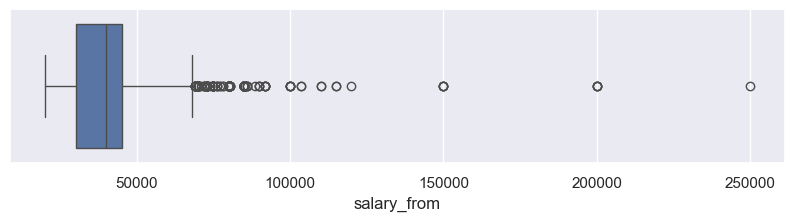

In [166]:
sns.set(rc={'figure.figsize':(10, 2)})

example = data_final[data_final.custom_position.str.contains('продавец')]
print(example.shape)
sns.boxplot(example.salary_from, orient='h')

(1532, 40)


<Axes: xlabel='salary_from'>

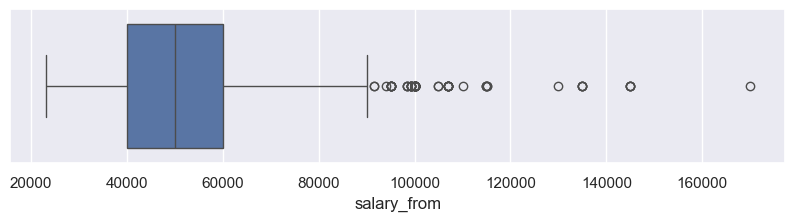

In [167]:
sns.set(rc={'figure.figsize':(10, 2)})

example = data_final[data_final.custom_position.str.contains('кладовщик')]
print(example.shape)
sns.boxplot(example.salary_from, orient='h')

(6666, 18)


<Axes: xlabel='salary_from'>

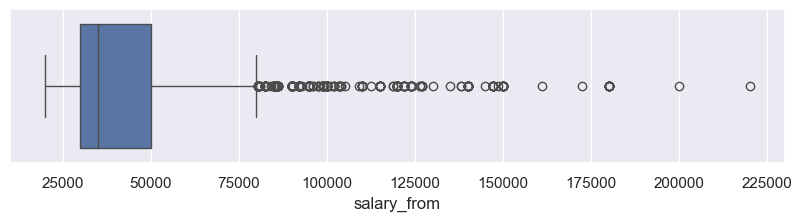

In [168]:
sns.set(rc={'figure.figsize':(10, 2)})

example = data[data.custom_position.str.contains('оператор')]
print(example.shape)
sns.boxplot(example.salary_from, orient='h')